# 🧠 Brain Tumor Detection using Vision Transformer (ViT)

This notebook trains a Vision Transformer model to classify MRI brain scans into multiple tumor types using the HuggingFace Transformers library. The dataset is loaded from a local folder structured by class, preprocessed with ViT image processors, and trained using a `Trainer` API.

---

## Environment Setup

Install required dependencies including TensorFlow, PyTorch, Transformers, and dataset utilities.
Make sure the correct conda environment is active before running installations.

In [ ]:
!pip install tensorflow

In [5]:
!pip install imutils

In [ ]:
!pip install transformers

In [ ]:
!pip install --upgrade torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

In [ ]:
pip install tf-keras

In [ ]:
!pip install datasets

In [ ]:
!pip install ipywidgets

In [ ]:
!pip install accelerate --upgrade

In [38]:
!pip show accelerate

Name: accelerate
Version: 1.12.0
Summary: Accelerate
Home-page: https://github.com/huggingface/accelerate
Author: The HuggingFace team
Author-email: zach.mueller@huggingface.co
License: Apache
Location: /Applications/anaconda3/lib/python3.12/site-packages
Requires: huggingface_hub, numpy, packaging, psutil, pyyaml, safetensors, torch
Required-by: 


## Import Libraries

Load core libraries for training, preprocessing, evaluation, and visualization.

In [7]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import LambdaLR
import random
import os
import numpy as np
from PIL import Image

from transformers import (
    ViTImageProcessor,
    ViTForImageClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback,
    get_cosine_schedule_with_warmup,
    TrainerCallback
)
from datasets import load_dataset, DatasetDict, ClassLabel
from sklearn.metrics import accuracy_score
from datetime import datetime
from time import time

import matplotlib.pyplot as plt

## Load Dataset

The dataset is loaded using the `imagefolder` format, where each subdirectory represents a label.

In [3]:
# Load using imagefolder with structured subdirectories
data = load_dataset("imagefolder", data_dir="dataset")

# Check number of samples
print(len(data["train"]))
print(len(data["test"]))

Resolving data files:   0%|          | 0/7227 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1760 [00:00<?, ?it/s]

7227
1760


In [9]:
from datasets import load_dataset, ClassLabel

# Fix random seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Load datasets
data = load_dataset(
    "imagefolder",
    data_files={
        "train": "dataset/training/**",
        "test": "dataset/testing/**"
    }
)

# Define class names
class_names = ['glioma', 'meningioma', 'no_tumor', 'pituitary', 'unknown']
class_label = ClassLabel(names=class_names)

# Assign labels based on folder names
def extract_label(example):
    filename = example["image"].filename.lower()
    for idx, cls in enumerate(class_names):
        if cls in filename:
            return {"label": class_label.str2int(cls)}
    return {"label": -1}

# Apply label extraction
data["train"] = data["train"].map(extract_label)
data["test"] = data["test"].map(extract_label)

# Cast label column
data["train"] = data["train"].cast_column("label", class_label)
data["test"] = data["test"].cast_column("label", class_label)

# Confirm counts
print(len(data["train"]))
print(len(data["test"]))
print(data["train"].features)

Resolving data files:   0%|          | 0/7227 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1760 [00:00<?, ?it/s]

Map:   0%|          | 0/7227 [00:00<?, ? examples/s]

Map:   0%|          | 0/1760 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/7227 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/1760 [00:00<?, ? examples/s]

7227
1760
{'image': Image(mode=None, decode=True), 'label': ClassLabel(names=['glioma', 'meningioma', 'no_tumor', 'pituitary', 'unknown'])}


### Dataset Collection

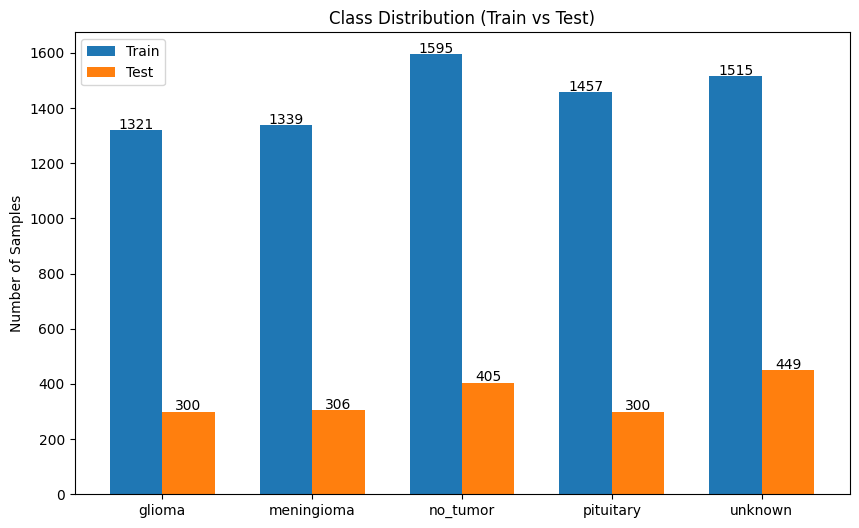

In [51]:
import matplotlib.pyplot as plt
import numpy as np

# Count labels
train_counts = data['train']['label']
test_counts = data['test']['label']

train_label_counts = np.bincount(train_counts)
test_label_counts = np.bincount(test_counts)

classes = labels  # assuming this lists class names in order
x = np.arange(len(classes))
width = 0.35

plt.figure(figsize=(10,6))
bars1 = plt.bar(x - width/2, train_label_counts, width, label='Train')
bars2 = plt.bar(x + width/2, test_label_counts, width, label='Test')

# Add counts on top of each bar
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5, str(yval), ha='center', fontsize=10)

for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5, str(yval), ha='center', fontsize=10)

plt.xticks(x, classes)
plt.ylabel("Number of Samples")
plt.title("Class Distribution (Train vs Test)")
plt.legend()
plt.show()

## Preprocessing & Label Encoding

Images are transformed using the ViT image processor and mapped to numerical labels. Labels are inferred from folder names, converted to a `ClassLabel`, and applied across dataset splits.


## Load Pretrained Model & Processor

A pretrained ViT Base Patch-16 (ImageNet-21K) model is loaded and adapted to five output classes:

- Glioma
- Meningioma
- Pituitary
- No Tumor
- Unknown

In [12]:
# Load pretrained processor
checkpoint = "google/vit-base-patch16-224-in21k"
processor = ViTImageProcessor.from_pretrained(checkpoint)

## Data Preprocessing & Augmentation

Augmentations applied to the training set include:

- Random Resized Crop
- Horizontal & Vertical Flips
- Rotation
- Color Jitter
- Mean/Std normalization from ViT processor

Validation data is resized and normalized without augmentation.

In [15]:
# Data augmentation (heavy for better generalization)
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=processor.image_mean, std=processor.image_std)
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=processor.image_mean, std=processor.image_std)
])

def transform_examples(example, transform):
    image = example['image']  # already PIL image
    image = transform(image)
    example['pixel_values'] = image
    return example

data['train'] = data['train'].map(lambda x: transform_examples(x, train_transforms))
data['test'] = data['test'].map(lambda x: transform_examples(x, val_transforms))
data.set_format(type="torch", columns=["pixel_values", "label"])

Map:   0%|          | 0/7227 [00:00<?, ? examples/s]

Map:   0%|          | 0/1760 [00:00<?, ? examples/s]

In [17]:
# Build model
labels = class_names
num_labels = len(labels)

model = ViTForImageClassification.from_pretrained(
    checkpoint,
    num_labels=num_labels,
    id2label={str(i): l for i, l in enumerate(labels)},
    label2id={l: str(i) for i, l in enumerate(labels)}
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Training Configuration

We configure TrainingArguments to train using:

- Epoch-based evaluation & checkpointing
- Learning rate 3e-5
- Batch size 16
- Warmup steps 500
- Weight decay 0.01
- Load best model at end (based on accuracy)
- pin_memory=False is set to avoid warnings on Apple M-series (MPS backend).

In [20]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./vit-brain-tumor",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-5,              # slightly lower LR for better stability
    per_device_train_batch_size=16,  # if OOM, reduce to 8
    per_device_eval_batch_size=16,
    num_train_epochs=20,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=3,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    fp16=False,
    seed=42,
    pin_memory=False, # disable for MPS
)

In [22]:
# Metrics function
def compute_metrics(pred):
    logits, labels = pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}

## Custom Callbacks

A custom TrainerCallback logs per-epoch timestamps, losses, and runtime.

In [25]:
# Custom Callback to Log Training Info and Time
class PrintLogsCallback(TrainerCallback):
    def __init__(self):
        self.epoch_start_time = None

    def on_epoch_begin(self, args, state, control, **kwargs):
        self.epoch_start_time = time()
        print(f"\nEpoch {int(state.epoch)} started...")

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs and state.epoch is not None:
            log_str = f"[Epoch {state.epoch:.2f}] " + " - ".join([f"{k}: {v:.4f}" for k, v in logs.items() if isinstance(v, float)])
            print(log_str)

    def on_epoch_end(self, args, state, control, **kwargs):
        duration = time() - self.epoch_start_time
        print(f"Epoch {int(state.epoch)} completed in {duration:.2f} seconds.\n")

In [27]:
# Learning Rate Scheduler (Linear Decay)
def get_scheduler(optimizer, num_warmup_steps, num_training_steps):
    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        return max(
            0.0, float(num_training_steps - current_step) / float(max(1, num_training_steps - num_warmup_steps))
        )
    return LambdaLR(optimizer, lr_lambda)

## Model Training

Train the ViT model using the HuggingFace `Trainer`. This section tracks epoch time, loss, and evaluation metrics.

In [30]:

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=data['train'],
    eval_dataset=data['test'],
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

In [32]:
# Print dataset stats before training
print(f"Train on {len(data['train'])} samples, Validate on {len(data['test'])} samples")

start_time = datetime.now()

trainer.train()

end_time = datetime.now()
elapsed = end_time - start_time
print(f"\nTotal training time: {elapsed}")


Train on 7227 samples, Validate on 1760 samples


/Applications/anaconda3/envs/tf/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy
1,0.270700,0.373979,0.925000
2,0.100700,0.338292,0.905114
3,0.048200,0.088731,0.978977
4,0.011500,0.166674,0.962500
5,0.035300,0.069078,0.984659
6,0.004600,0.087483,0.982955
7,0.003500,0.097674,0.980682
8,0.002400,0.093215,0.982386


/Applications/anaconda3/envs/tf/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Applications/anaconda3/envs/tf/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Applications/anaconda3/envs/tf/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Applications/anaconda3/envs/tf/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Applications/anaconda3/envs/tf/lib/python3.


Total training time: 1:21:04.443275


## Evaluation

Evaluate model accuracy on the test dataset and generate detailed classification metrics like precision, recall, and F1 score.

In [34]:
# Evaluate After Training
eval_results = trainer.evaluate()
print("Evaluation results:", eval_results)

# Make predictions
preds = trainer.predict(data["test"])
pred_labels = np.argmax(preds.predictions, axis=1)

/Applications/anaconda3/envs/tf/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Evaluation results: {'eval_loss': 0.06907809525728226, 'eval_accuracy': 0.9846590909090909, 'eval_runtime': 42.7769, 'eval_samples_per_second': 41.144, 'eval_steps_per_second': 2.571, 'epoch': 8.0}


/Applications/anaconda3/envs/tf/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


In [38]:
from sklearn.metrics import classification_report

outputs = trainer.predict(data['test'])
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(axis=1)

print(classification_report(y_true, y_pred, target_names=labels))

/Applications/anaconda3/envs/tf/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


              precision    recall  f1-score   support

      glioma       0.97      0.98      0.98       300
  meningioma       0.97      0.96      0.97       306
    no_tumor       0.99      1.00      0.99       405
   pituitary       0.99      0.99      0.99       300
     unknown       1.00      0.99      1.00       449

    accuracy                           0.98      1760
   macro avg       0.98      0.98      0.98      1760
weighted avg       0.98      0.98      0.98      1760



## Visualize Predictions

Randomly select samples from the test dataset, run inference, and display predicted vs. true labels alongside MRI images.

Resolving data files:   0%|          | 0/7227 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1760 [00:00<?, ?it/s]

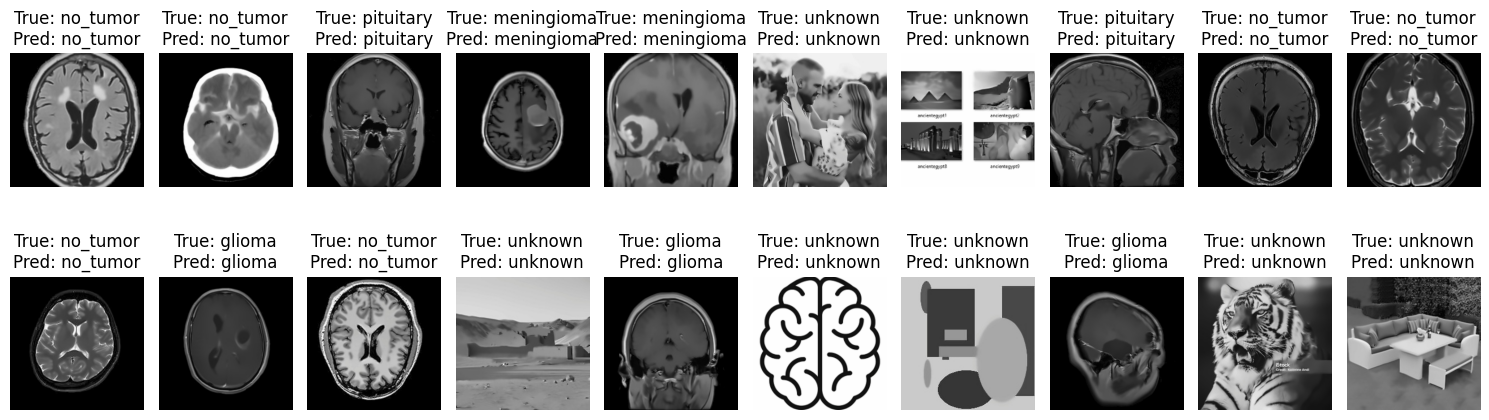

In [36]:
# Use original image dataset for visualization
raw_test = load_dataset("imagefolder", data_dir="dataset")["test"]

# Create map for id to label name
id2label = {i: label for i, label in enumerate(labels)}

# Sample some test images
num_samples = 20
samples = raw_test.shuffle(seed=42).select(range(num_samples))

images = [sample["image"].convert("RGB") for sample in samples]
true_labels = [sample["label"] for sample in samples]

# Run prediction
inputs = processor(images=images, return_tensors="pt").to(model.device)
with torch.no_grad():
    logits = model(**inputs).logits
    preds = torch.argmax(logits, dim=1).cpu().numpy()

# Plot
plt.figure(figsize=(15, 5))
for i, (img, true, pred) in enumerate(zip(images, true_labels, preds)):
    plt.subplot(2, 10, i + 1)
    plt.imshow(img, cmap="gray")
    plt.title(f"True: {id2label[true]}\nPred: {id2label[pred]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

## Save Best Model

The full fine-tuned model and processor are saved for deployment and inference.

In [40]:
# Save full model & processor
model_dir = "./vit_brain_tumor_best_model"
trainer.save_model(model_dir)
processor.save_pretrained(model_dir)

['./vit_brain_tumor_best_model/preprocessor_config.json']

In [ ]:
from transformers import ViTForImageClassification, ViTImageProcessor
# reload the model if needed
model_dir = "./vit_brain_tumor_best_model"

model = ViTForImageClassification.from_pretrained(model_dir)
processor = ViTImageProcessor.from_pretrained(model_dir)

## Acknowledgment

This project uses data sourced from the **[Brain Tumor MRI Dataset](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset/data)** provided by **Masoud Nickparvar** on Kaggle.  
The dataset contains MRI scans categorized into:

- **Glioma**
- **Meningioma**
- **Pituitary Tumor**
- **No Tumor**

An additional **Unknown / Unclassified** category was manually collected using publicly available images from Google Search to assist with generalization and out-of-distribution testing.